In [2]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

Define Data Loading Functions

In [3]:
def load_usgs_data(station_folder):
    """Loads and prepares USGS observation data for a specific station."""
    usgs_file_path = glob.glob(os.path.join(station_folder, "*_Strt_*.csv"))
    if not usgs_file_path:
        raise FileNotFoundError(f"No USGS data file found in {station_folder}")
    
    df = pd.read_csv(usgs_file_path[0])
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df = df.set_index('DateTime')
    return df

def load_nwm_forecasts(station_folder):
    """Loads, combines, and prepares all NWM forecast files for a station."""
    nwm_path = os.path.join(station_folder, "nwm_forecasts")
    nwm_files = glob.glob(os.path.join(nwm_path, "streamflow_*.csv"))
    if not nwm_files:
        raise FileNotFoundError(f"No NWM forecast files found in {nwm_path}")
    
    forecast_list = []
    for f in nwm_files:
        df = pd.read_csv(f)
        df['model_initialization_time'] = pd.to_datetime(df['model_initialization_time'], format='%Y-%m-%d_%H:%M:%S')
        df['model_output_valid_time'] = pd.to_datetime(df['model_output_valid_time'], format='%Y-%m-%d_%H:%M:%S')
        df['lead_time'] = (df['model_output_valid_time'] - df['model_initialization_time']).dt.total_seconds() / 3600
        forecast_list.append(df)
        
    return pd.concat(forecast_list, ignore_index=True)

Set Paths and Load Data

In [4]:
data_path = "../data/raw"
processed_path = "../data/processed"
os.makedirs(processed_path, exist_ok=True)

stations = ["station1", "station2"]
station_data = {}

for station in stations:
    print(f"--- Processing data for {station} ---")
    station_folder = os.path.join(data_path, station)
    
    # Load data using the functions
    usgs_df = load_usgs_data(station_folder)
    nwm_df = load_nwm_forecasts(station_folder)
    
    print(f"Loaded {len(usgs_df)} USGS observations.")
    print(f"Loaded {len(nwm_df)} NWM forecast points.")
    
    # Store in dictionary
    station_data[station] = {'usgs': usgs_df, 'nwm': nwm_df}

    # Save processed data for this station as a Parquet file
    # Note: Merging/aligning will happen in the next notebook, here we just save the clean, loaded data.
    usgs_table = pa.Table.from_pandas(usgs_df)
    nwm_table = pa.Table.from_pandas(nwm_df)
    
    pq.write_table(usgs_table, os.path.join(processed_path, f"{station}_usgs.parquet"))
    pq.write_table(nwm_table, os.path.join(processed_path, f"{station}_nwm.parquet"))
    print(f"Saved cleaned USGS and NWM data for {station} to {processed_path}\n")


--- Processing data for station1 ---
Loaded 70089 USGS observations.
Loaded 326160 NWM forecast points.
Saved cleaned USGS and NWM data for station1 to ../data/processed

--- Processing data for station2 ---
Loaded 65498 USGS observations.
Loaded 326160 NWM forecast points.
Saved cleaned USGS and NWM data for station2 to ../data/processed



Exploratory Data Analysis



Exploratory analysis for station1

USGS Observation Statistics:
count    70089.000000
mean         0.252910
std          0.141788
min          0.050000
25%          0.180000
50%          0.240000
75%          0.310000
max          4.080000
Name: USGSFlowValue, dtype: float64

Missing values in USGS data:
USGSFlowValue    0
USGS_GageID      0
dtype: int64

USGS data time range:
Start: 2021-04-20 07:00:00+00:00
End: 2023-04-22 06:45:00+00:00

Time intervals in USGS data:
DateTime
0 days 00:15:00    70027
0 days 01:00:00       61
Name: count, dtype: int64

NWM Forecast Statistics:
count    326159.000000
mean         53.964562
std          46.555739
min           0.300000
25%          20.660000
50%          48.619999
75%          71.339998
max         764.009983
Name: streamflow_value, dtype: float64

Missing values in NWM data:
NWM_version_number           0
model_initialization_time    0
model_output_valid_time      0
streamflow_value             1
streamID                     0
lead_t

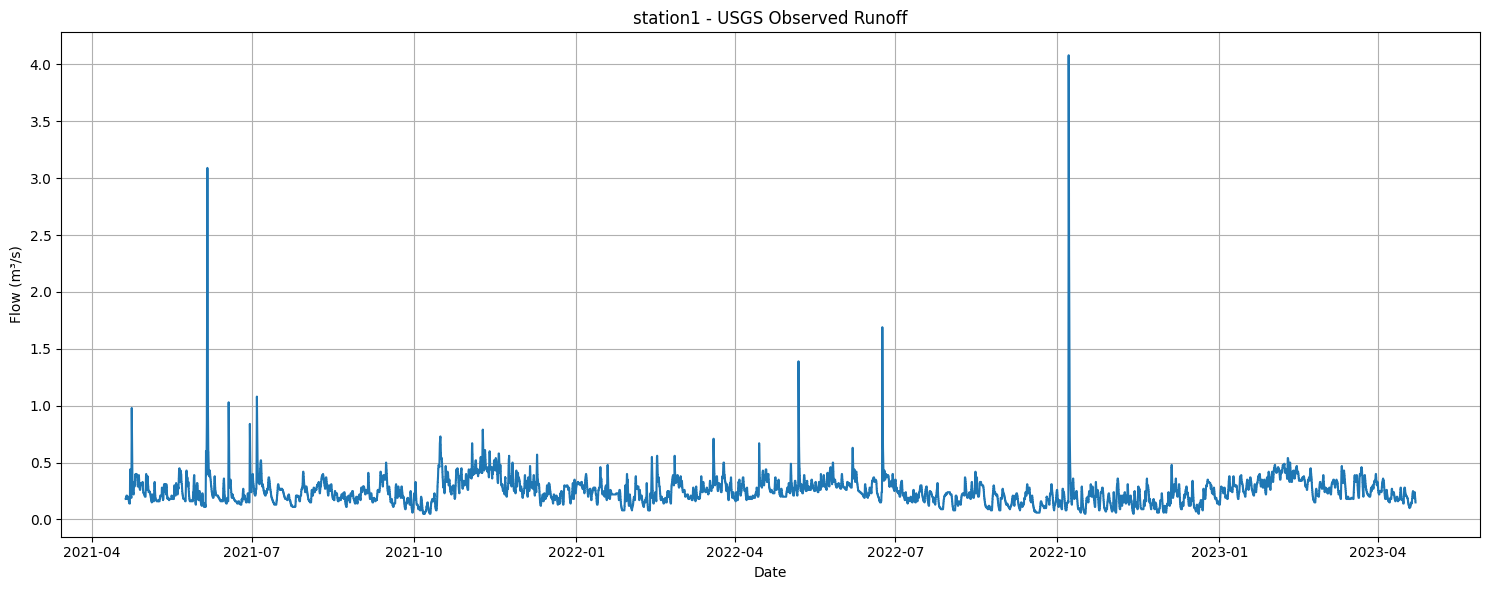

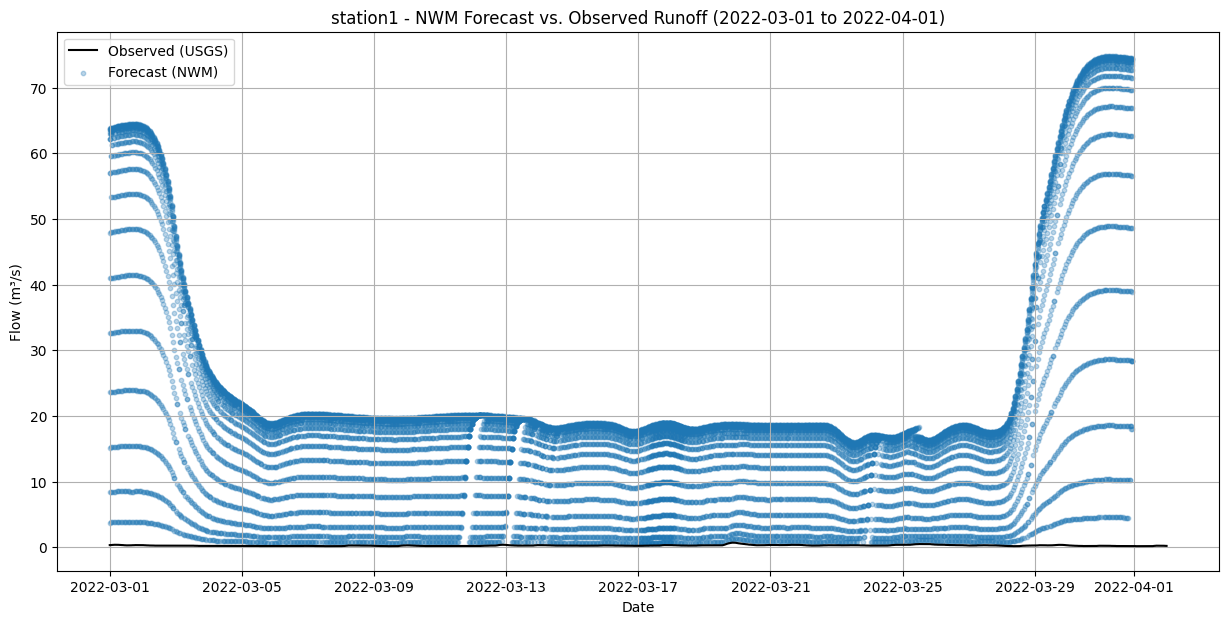


Aligning NWM forecasts with USGS observations...

Created aligned dataset with 326105 points.


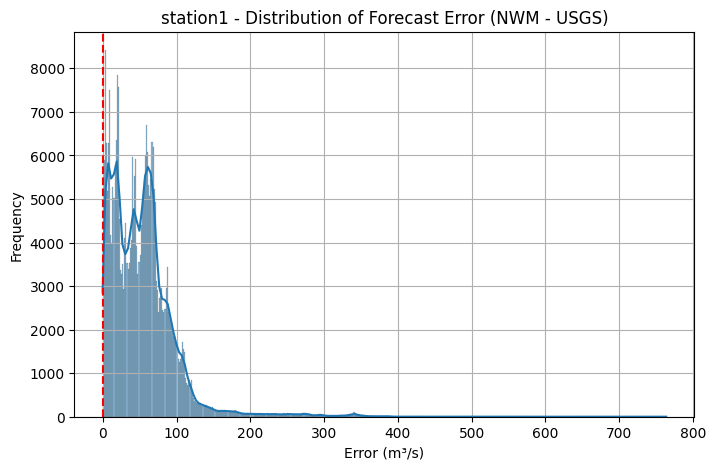

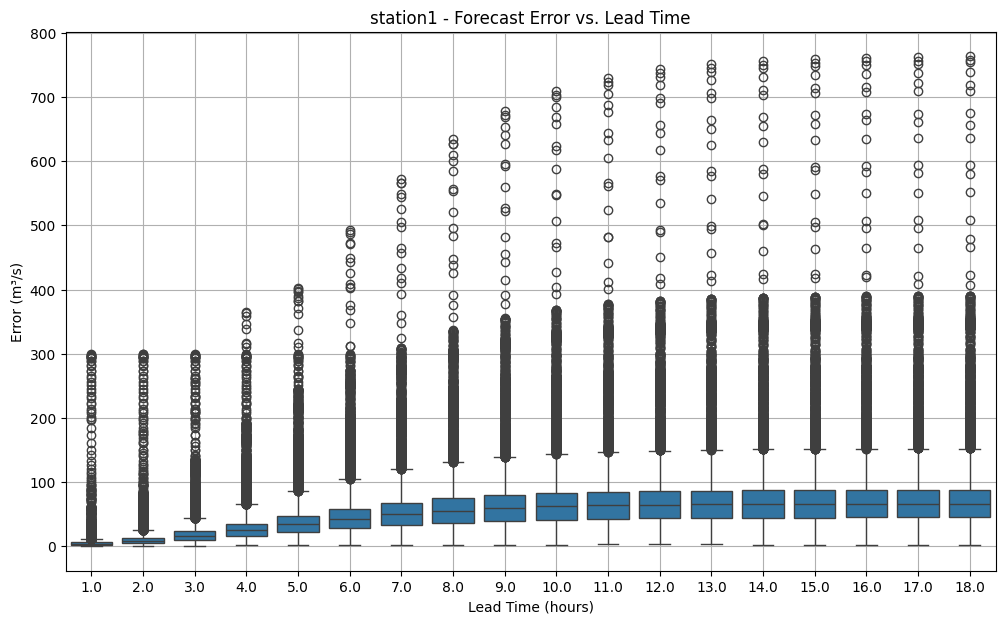



Exploratory analysis for station2

USGS Observation Statistics:
count    65483.000000
mean        12.602763
std         15.002914
min          0.230000
25%          1.740000
50%          6.990000
75%         17.560000
max        136.200000
Name: USGSFlowValue, dtype: float64

Missing values in USGS data:
USGSFlowValue    15
00060_cd         15
dtype: int64

USGS data time range:
Start: 2021-04-20 07:00:00+00:00
End: 2023-04-22 06:45:00+00:00

Time intervals in USGS data:
DateTime
0 days 00:15:00    65056
0 days 02:00:00      305
0 days 06:00:00      111
0 days 00:30:00        7
0 days 01:15:00        6
0 days 00:45:00        4
0 days 01:00:00        3
0 days 01:45:00        2
0 days 01:30:00        2
0 days 04:15:00        1
Name: count, dtype: int64

NWM Forecast Statistics:
count    326160.000000
mean         11.441092
std          16.141266
min           0.150000
25%           1.390000
50%           5.030000
75%          13.000000
max         129.279997
Name: streamflow_value, dty

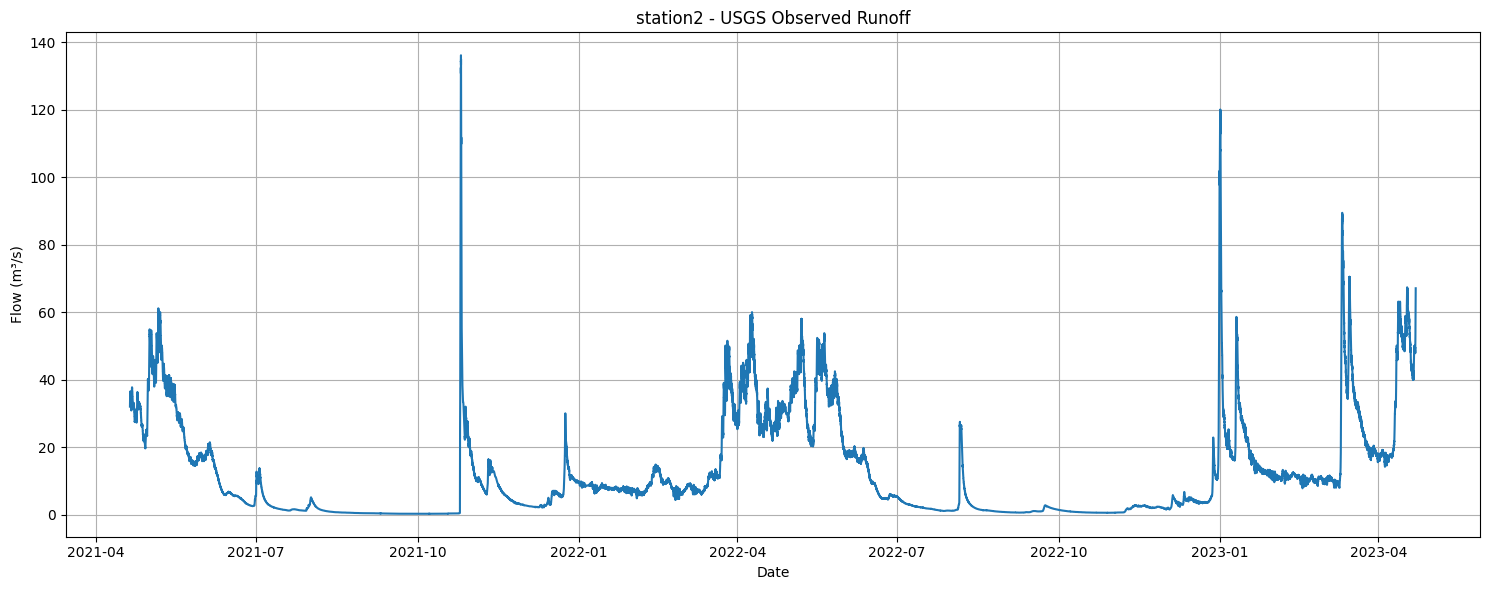

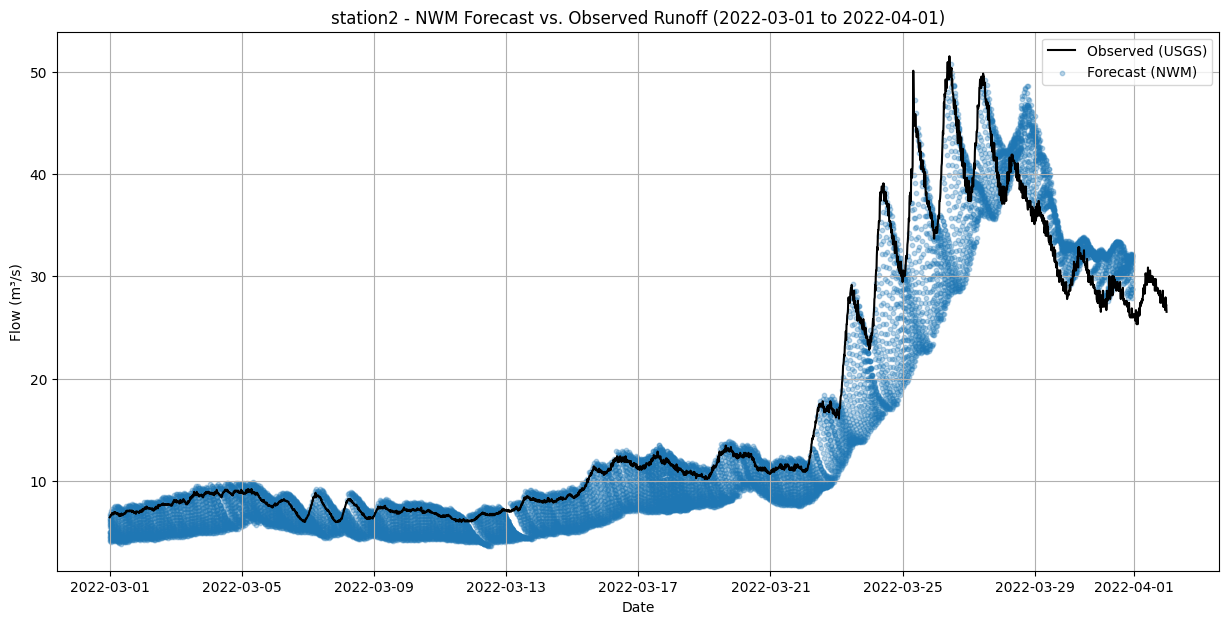


Aligning NWM forecasts with USGS observations...

Created aligned dataset with 310085 points.


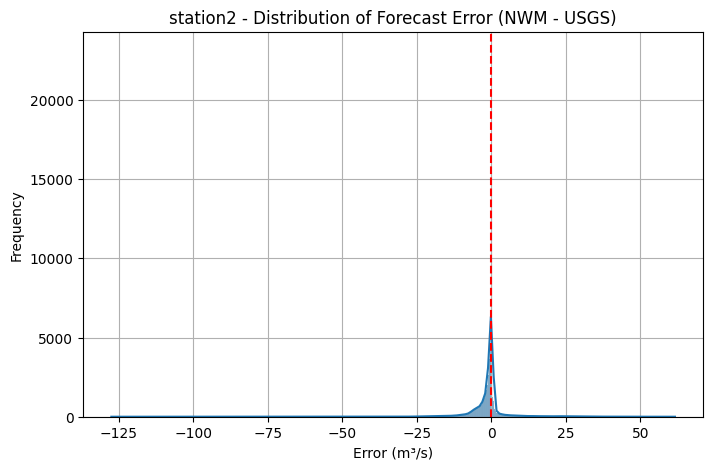

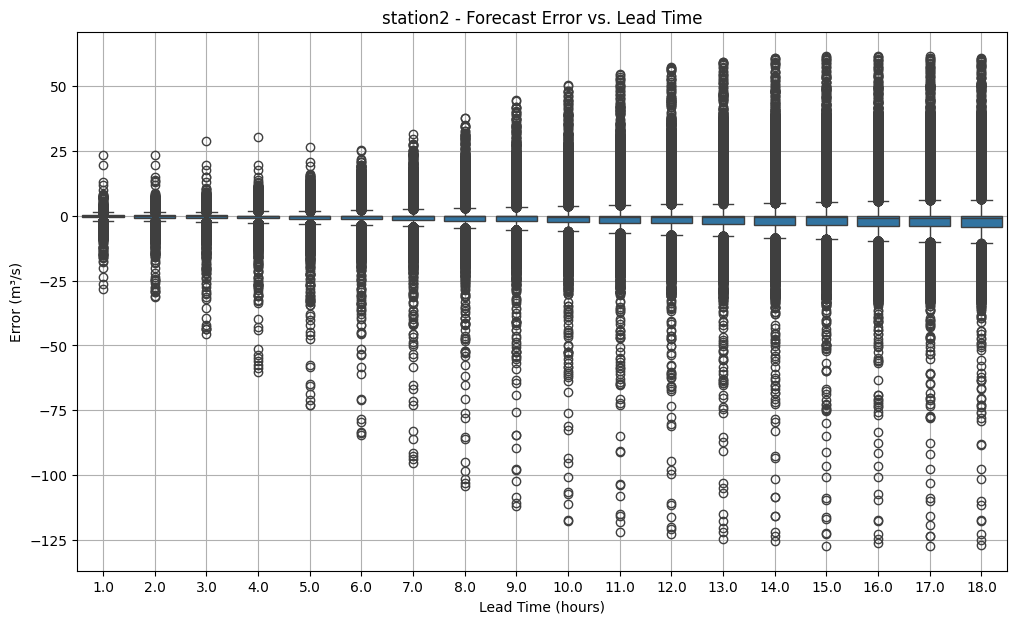

In [6]:
os.makedirs("../data/figures", exist_ok=True)

for station_name, data in station_data.items():
    usgs_data = data['usgs']
    nwm_data = data['nwm']
    
    print(f"\n\n{'='*50}")
    print(f"Exploratory analysis for {station_name}")
    print(f"{'='*50}")
    
    # Basic stats of USGS observations
    print("\nUSGS Observation Statistics:")
    print(usgs_data['USGSFlowValue'].describe())
    
    # Check for missing values
    missing_usgs = usgs_data.isnull().sum()
    print("\nMissing values in USGS data:")
    print(missing_usgs)
    
    # Time series properties of USGS data
    print("\nUSGS data time range:")
    print(f"Start: {usgs_data.index.min()}")
    print(f"End: {usgs_data.index.max()}")
    
    # Check time intervals
    time_diffs = usgs_data.index.to_series().diff().value_counts()
    print("\nTime intervals in USGS data:")
    print(time_diffs)
    
    # NWM Forecast Statistics
    print("\nNWM Forecast Statistics:")
    print(nwm_data['streamflow_value'].describe())
    
    # Check for missing values
    missing_nwm = nwm_data.isnull().sum()
    print("\nMissing values in NWM data:")
    print(missing_nwm)
    
    # Check NWM initialization times
    init_times = nwm_data['model_initialization_time'].unique()
    print(f"\nNumber of unique forecast initialization times: {len(init_times)}")
    print(f"First initialization time: {init_times.min()}")
    print(f"Last initialization time: {init_times.max()}")
    
    # Check lead times
    lead_times = nwm_data['lead_time'].unique()
    print(f"\nAvailable lead times: {sorted(lead_times)}")
    
    # Create visulizations
    
    # USGS time series plot
    plt.figure(figsize=(15, 6))
    plt.plot(usgs_data.index, usgs_data['USGSFlowValue'])
    plt.title(f'{station_name} - USGS Observed Runoff')
    plt.xlabel('Date')
    plt.ylabel('Flow (m³/s)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../data/figures/{station_name}_usgs_timeseries.png")
    plt.show()
    
     # --- NEW: Overlay Plot for Direct Comparison ---
    # Create a time slice for a clearer plot (e.g., one month)
    sample_period_start = '2022-03-01'
    sample_period_end = '2022-04-01'
    usgs_sample = usgs_data[sample_period_start:sample_period_end]
    
    # Get NWM data valid within this period
    nwm_sample = nwm_data[
        (nwm_data['model_output_valid_time'] >= sample_period_start) &
        (nwm_data['model_output_valid_time'] < sample_period_end)
    ]
    
    plt.figure(figsize=(15, 7))
    plt.plot(usgs_sample.index, usgs_sample['USGSFlowValue'], label='Observed (USGS)', color='black', zorder=5)
    # Scatter plot for NWM forecasts to show multiple lead times for each point
    plt.scatter(nwm_sample['model_output_valid_time'], nwm_sample['streamflow_value'], 
                label='Forecast (NWM)', alpha=0.3, s=10)
    plt.title(f'{station_name} - NWM Forecast vs. Observed Runoff ({sample_period_start} to {sample_period_end})')
    plt.xlabel('Date'); plt.ylabel('Flow (m³/s)'); plt.grid(True); plt.legend()
    plt.savefig(f"../data/figures/{station_name}_overlay_comparison.png")
    plt.show()

    # Align Data and Analyze Forecast Error
    print("\nAligning NWM forecasts with USGS observations...")
    
    # Sort data for efficient merging
    usgs_data_sorted = usgs_data.sort_index()
    nwm_data_sorted = nwm_data.sort_values(by='model_output_valid_time')

    # Ensure both keys are timezone-aware (UTC) for merge_asof
    nwm_data_sorted = nwm_data_sorted.copy()
    if nwm_data_sorted['model_output_valid_time'].dt.tz is None:
        nwm_data_sorted['model_output_valid_time'] = nwm_data_sorted['model_output_valid_time'].dt.tz_localize('UTC')
    # usgs_data_sorted.index should already be tz-aware (UTC), but check and fix if not
    if usgs_data_sorted.index.tz is None:
        usgs_data_sorted = usgs_data_sorted.tz_localize('UTC')

    # Align NWM forecasts to the closest preceding USGS observation time
    aligned_df = pd.merge_asof(
        left=nwm_data_sorted,
        right=usgs_data_sorted,
        left_on='model_output_valid_time',
        right_index=True,
        direction='nearest',
        tolerance=pd.Timedelta(minutes=30) # Match within a 30-minute window
    )
    
    # Calculate the error
    aligned_df.dropna(subset=['USGSFlowValue'], inplace=True)
    aligned_df['error'] = aligned_df['streamflow_value'] - aligned_df['USGSFlowValue']
    
    print(f"\nCreated aligned dataset with {len(aligned_df)} points.")
    
    # Plot Error Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(aligned_df['error'], kde=True)
    plt.title(f'{station_name} - Distribution of Forecast Error (NWM - USGS)')
    plt.xlabel('Error (m³/s)'); plt.ylabel('Frequency')
    plt.grid(True)
    plt.axvline(0, color='red', linestyle='--')
    plt.savefig(f"../data/figures/{station_name}_error_distribution.png")
    plt.show()
    
    # Plot Error vs. Lead Time
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=aligned_df, x='lead_time', y='error')
    plt.title(f'{station_name} - Forecast Error vs. Lead Time')
    plt.xlabel('Lead Time (hours)'); plt.ylabel('Error (m³/s)')
    plt.grid(True)
    plt.savefig(f"../data/figures/{station_name}_error_vs_leadtime.png")
    plt.show()
    
    # Save statistics and convert to DataFrame
    summary = {
        'Station': station_name,
        'USGS_data_points': len(usgs_data),
        'USGS_missing': missing_usgs['USGSFlowValue'],
        'USGS_min_flow': usgs_data['USGSFlowValue'].min(),
        'USGS_max_flow': usgs_data['USGSFlowValue'].max(),
        'USGS_mean_flow': usgs_data['USGSFlowValue'].mean(),
        'NWM_data_points': len(nwm_data),
        'NWM_missing': missing_nwm['streamflow_value'],
        'NWM_min_flow': nwm_data['streamflow_value'].min(),
        'NWM_max_flow': nwm_data['streamflow_value'].max(),
        'NWM_mean_flow': nwm_data['streamflow_value'].mean(),
        'Forecast_init_count': len(init_times),
        'Lead_times': sorted(lead_times)
    }
    
    summary_df = pd.DataFrame([summary])
    summary_df.to_csv(f"../data/processed/{station_name}_summary.csv", index=False)